# Assignment 1: Optical flow

In [3]:
import numpy as np
import cv2
from ex1_utils import gaussderiv, rotate_image, show_flow, gausssmooth
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Base functions

In [4]:
def lucaskanade (im1, im2, N,sigma = 1, include_harris=False):
    """Function for calculating the optical flow using the Lucas-Kanade method"""
    # Define a sigma that changes with the size of the image, for appropriate derivatives
    Ix, Iy = gaussderiv((im1+im2)/2, sigma) 
    # Get the time derivative, add gaussian smoothing
    It = gausssmooth(im2-im1, sigma)
    sum_kernel = np.ones(shape=(N,N), dtype=np.float32)
    # Calculate sums of squared derivative images, using convolution instead of loops
    sum_Ix2 = cv2.filter2D(src=Ix*Ix, ddepth=-1, kernel=sum_kernel)
    sum_Iy2 = cv2.filter2D(src=Iy*Iy, ddepth=-1, kernel=sum_kernel)
    sum_Ix_Iy = cv2.filter2D(src=Ix*Iy, ddepth=-1, kernel=sum_kernel)
    sum_Ix_It = cv2.filter2D(src=Ix*It, ddepth=-1, kernel =sum_kernel)
    sum_Iy_It = cv2.filter2D(src=Iy*It, ddepth=-1, kernel =sum_kernel)

    # Calculate the determinant
    D = sum_Ix2 * sum_Iy2 - sum_Ix_Iy * sum_Ix_Iy 
    u = np.zeros(shape=im1.shape)
    v = np.zeros(shape=im1.shape)

    if include_harris:
        # Harris criterion for corner detection
        K = 0.05
        trace = sum_Ix2 + sum_Iy2
        c = D -  K * trace**2
        # Treshold to consider where the criterion is low
        tresh = 1e-7
        # Get indices where the criterion exceeds the treshold
        indices = np.where((c > tresh) & (np.abs(D) != 0))

        u[indices] =  - (sum_Iy2[indices] * sum_Ix_It[indices] -  sum_Ix_Iy[indices] * sum_Iy_It[indices])/D[indices]
        v[indices] = - (sum_Ix2[indices] * sum_Iy_It[indices] - sum_Ix_Iy[indices] * sum_Ix_It[indices])/D[indices]
    
    else:
        # Get the flow field, prevent division by 0
        indices = np.where(D != 0)

        u[indices] =  - (sum_Iy2[indices] * sum_Ix_It[indices] -  sum_Ix_Iy[indices] * sum_Iy_It[indices])/D[indices]
        v[indices] = - (sum_Ix2[indices] * sum_Iy_It[indices] - sum_Ix_Iy[indices] * sum_Ix_It[indices])/D[indices]
    
    return u,v

def hornschunck (im1, im2, n_iters, lmbd, sigma, convergence_tresh=-1, start_u = [], start_v = []):
    """Function for calculating the optical flow using the Horn-Schnuck method"""
    # Smooth the images 
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)
    # Get the spatial derivatives
    Ix, Iy = gaussderiv((im1+im2)/2, sigma) 
    # Get the time derivative
    It =gausssmooth(im2-im1, sigma)
    # Initialize u,v start with zeros if nothing is inputted
    u = start_u
    v = start_v
    if len(u) == 0:
        u = np.zeros(shape = im1.shape)
    if len(v) == 0:
        v = np.zeros(shape = im1.shape)

    # Laplacian kernel
    Ld = np.array([[0,0.25,0],[0.25,0,0.25], [0,0.25,0]])

    # Iterate until convergence or hitting the limit for iterations
    for n in range(n_iters):
        ua = cv2.filter2D(u, -1,Ld)
        va = cv2.filter2D(v, -1, Ld) 

        P = Ix * ua + Iy* va + It
        D = lmbd + Ix*Ix + Iy*Iy

        u_tmp = ua - Ix * P/D
        v_tmp = va - Iy * P/D

        # Define convergence 
        avg_diff = (np.sum((u-u_tmp)**2 + (v-v_tmp)**2)) /(im1.shape[0] * im1.shape[1])
        # minimal iterations = 100
        if n > 1 and avg_diff < convergence_tresh:
            break
        u = u_tmp
        v = v_tmp
        
    return u,v


In [5]:
# Functions for subplotting for testing
def subplot_field_lk(im1, im2, N, sigma,harris, title=""):
    fig1, ax = plt.subplots(2, 2)

    ax1_11, ax1_12 = ax[0]
    ax1_21, ax1_22 = ax[1]

    ax1_11.imshow(im1)
    ax1_12.imshow(im2)

    U, V = lucaskanade(im1, im2, N,sigma, harris)
    show_flow(U, V, ax1_21, type="angle")
    show_flow(U, V, ax1_22, type="field", set_aspect=True)

    fig1.suptitle(title)
    
    plt.show()

def subplot_field_hc(im1, im2, n_iters,lmbd , sigma,convergence_tresh, title="", u_start=[], v_start=[]):
    fig1, ax = plt.subplots(2, 2)

    ax1_11, ax1_12 = ax[0]
    ax1_21, ax1_22 = ax[1]

    ax1_11.imshow(im1)
    ax1_12.imshow(im2)

    U, V = hornschunck(im1,im2, n_iters, lmbd, sigma, convergence_tresh, u_start, v_start)
    show_flow(U, V, ax1_21, type="angle")
    show_flow(U, V, ax1_22, type="field", set_aspect=True)


    fig1.suptitle(title)

    plt.show()

## Testing base functions on noise

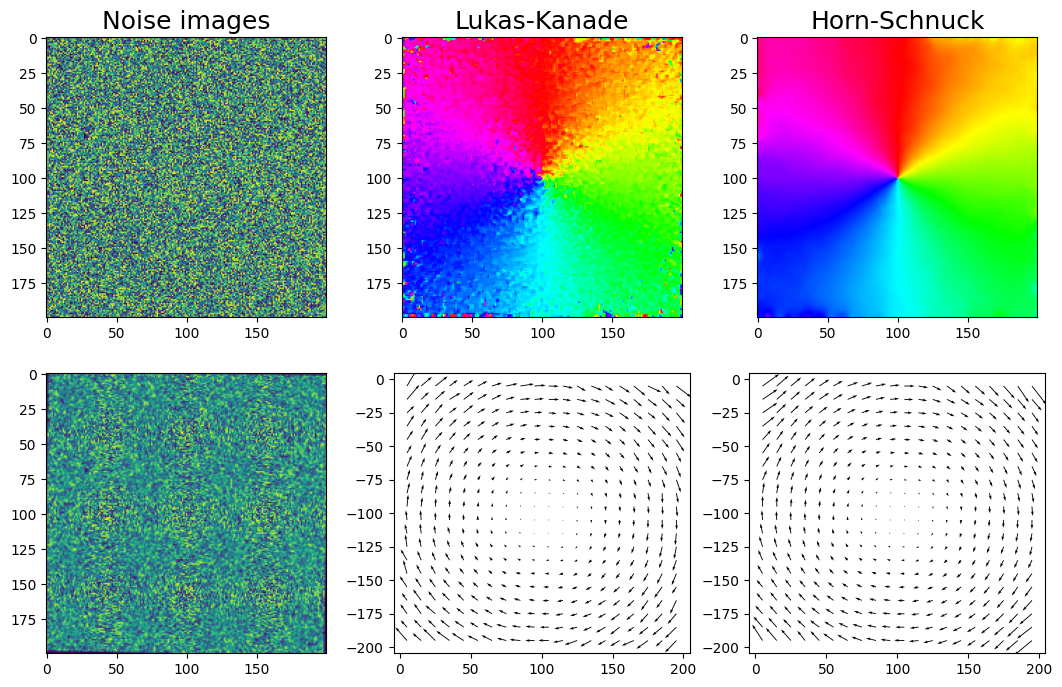

In [84]:
# Testing on noise
np.random.seed(42)
im1 = np.random.rand(200,200).astype(np.float32)
im2 = im1.copy()
im2 = rotate_image(im2,-1)
# Set the params
sigma = im1.shape[1] / 170.0
N = 3 #for LK
#for HS
lmbd = .5 
n_iter = 1000
# Testing 
# subplot_field_lk(im1,im2, N=N, harris=False,sigma=sigma, title="Lukas-Kanade")
# subplot_field_hc(im1,im2,10000, lmbd, sigma, 1e-7, title="Horn-Schnuck")

# Subplot for report
fig,ax = plt.subplots(2,3, figsize=(13,8))
ax_11, ax_12, ax_13 = ax[0]
ax_21, ax_22, ax_23 = ax[1]

ax_11.set_title("Noise images", fontsize=18)
ax_12.set_title("Lukas-Kanade", fontsize=18)
ax_13.set_title("Horn-Schnuck", fontsize=18)

# Display images
ax_11.imshow(im1)
ax_21.imshow(im2)
# Get LK flow and display it
U,V = lucaskanade(im1,im2, N, sigma, False)
show_flow(U, V, ax_12, type="angle")
show_flow(U,V, ax_22, type = "field")
# Get HS flow and display it 
U,V = hornschunck(im1,im2, n_iter, lmbd, sigma, convergence_tresh=1e-7)
show_flow(U, V, ax_13, type="angle")
show_flow(U,V, ax_23, type = "field")
fig.savefig("report/figures/noise.png")

## Testing base function on video

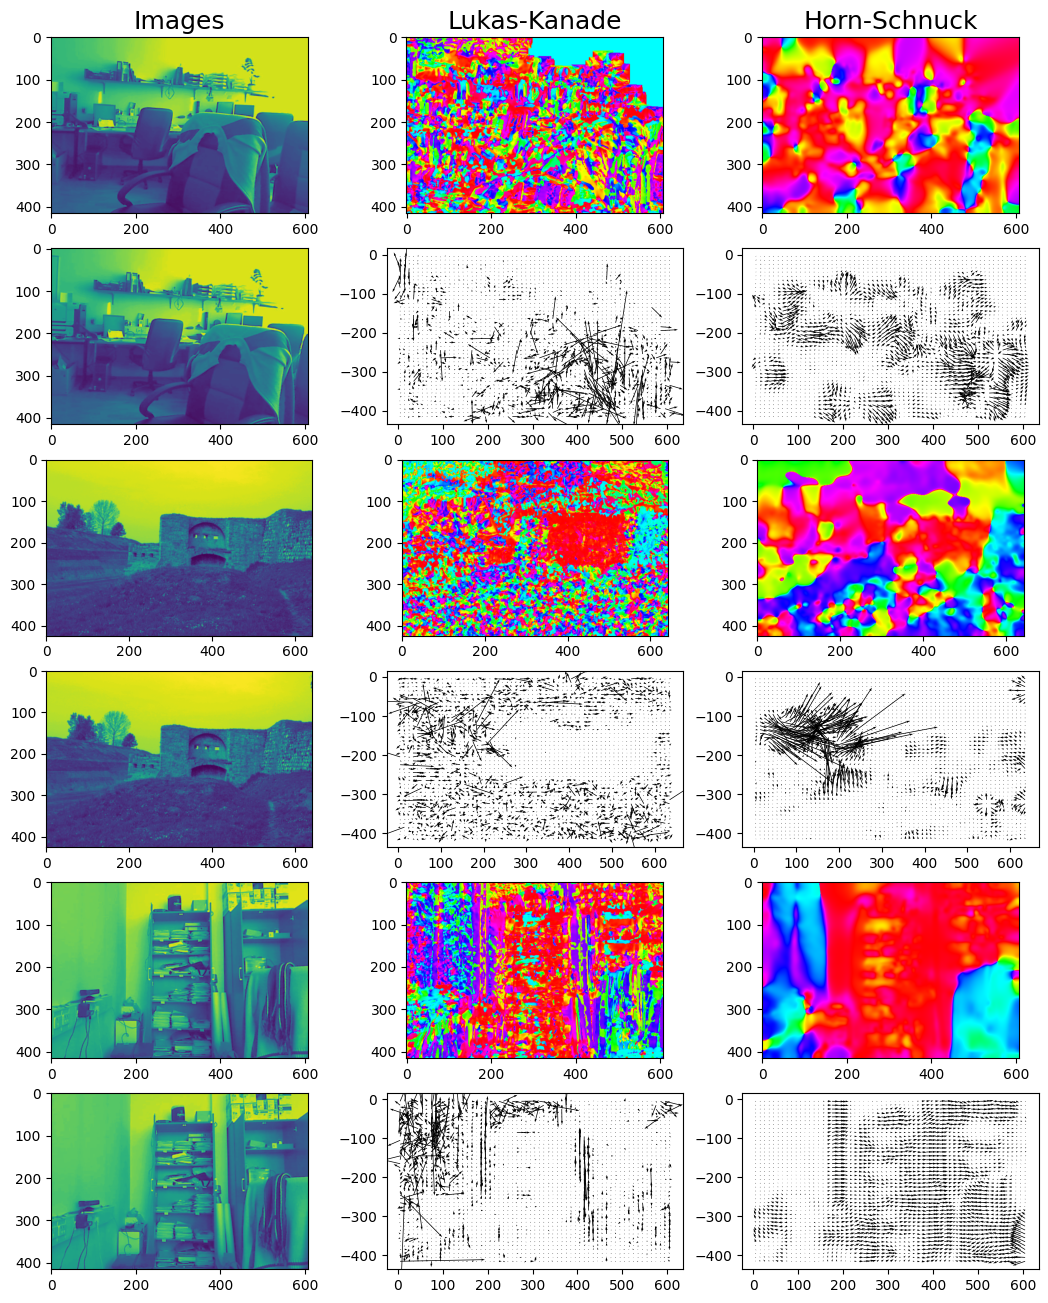

In [85]:
# Testing on other images
images_1 = []
images_2 = []
im1 = cv2.imread("disparity/office_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/office_right.png",cv2.IMREAD_GRAYSCALE)/255.0
images_1.append(im1)
images_2.append(im2)
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_hc(im1,im2, 10000, lmbd, sigma,convergence, "Horn-Schunck optical flow")

im1 = cv2.imread("disparity/cporta_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/cporta_right.png", cv2.IMREAD_GRAYSCALE)/255.0
images_1.append(im1)
images_2.append(im2)
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_hc(im1,im2, 10000, lmbd, sigma,convergence, "Horn-Schunck optical flow")

im1 = cv2.imread("disparity/office2_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/office2_right.png", cv2.IMREAD_GRAYSCALE)/255.0
images_1.append(im1)
images_2.append(im2)
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_hc(im1,im2, 10000, lmbd, sigma,convergence, "Horn-Schunck optical flow")

# Include only 3 images otherwise the plot is too large

# im1 = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# images_1.append(im1)
# images_2.append(im2)
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_hc(im1,im2, 10000, lmbd, sigma,convergence, "Horn-Schunck optical flow")

# im1 = cv2.imread("lab2/001.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("lab2/002.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# images_1.append(im1)
# images_2.append(im2)
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_hc(im1,im2, 10000, lmbd, sigma,convergence, "Horn-Schunck optical flow")

# Set the params
N = 3
lmbd = 0.5
convergence = 1e-7
n_iter = 10000
sigma = im1.shape[1] / 170.0
# Report subplot (take 3 examples only otherwise too large plot)
fig, ax = plt.subplots(6, 3, figsize=(13,16))
for i,row in enumerate(ax):
    if i %2==0:
        im1 = images_1[int(i/2)]
        im2 = images_2[int(i/2)]
        row[0].imshow(im1)
        U_lk,V_lk = lucaskanade(im1,im2, N, sigma, False)
        show_flow(U_lk, V_lk, row[1], type="angle")
        U,V = hornschunck(im1,im2, n_iter, lmbd, sigma, convergence_tresh=convergence)
        show_flow(U, V, row[2], type="angle")

    else:
        row[0].imshow(im2)
        show_flow(U_lk,V_lk, row[1], type = "field")
        show_flow(U,V,  row[2], type = "field")


ax[0, 0].set_title("Images", fontsize=18)
ax[0,1].set_title("Lukas-Kanade", fontsize=18)
ax[0,2].set_title("Horn-Schnuck", fontsize=18)
fig.savefig("report/figures/images_base.png")


## Harris addition for lukas kanade

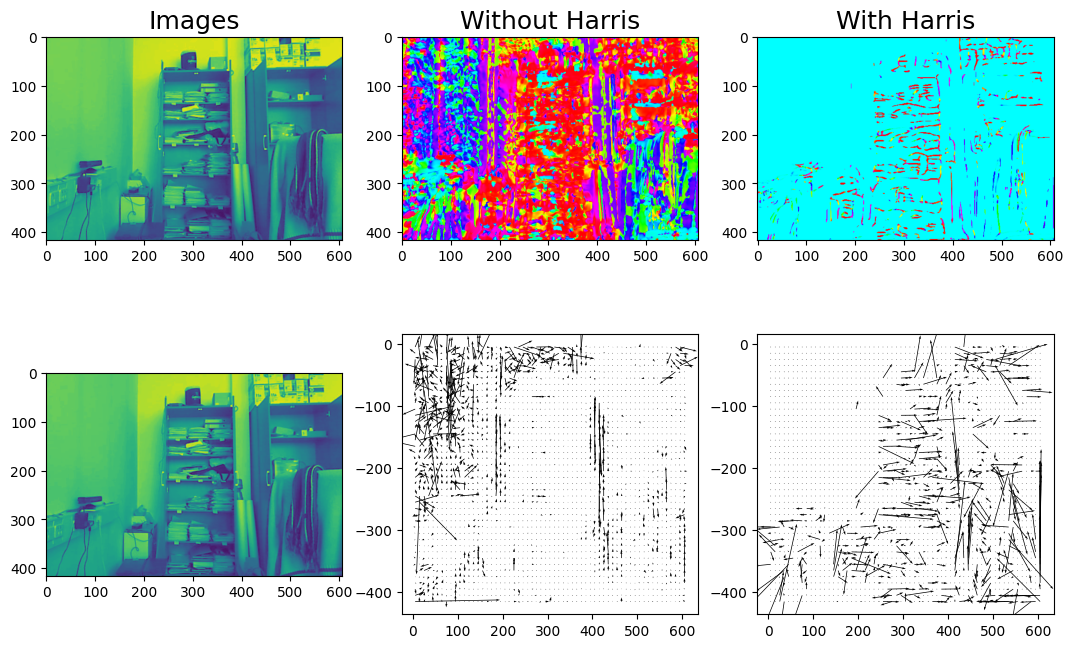

In [ ]:
# Testing the harris addition for lukas kanade
im1 = cv2.imread("disparity/office2_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/office2_right.png",cv2.IMREAD_GRAYSCALE)/255.0
N = 3
sigma = im1.shape[1] / 170.0
# Testing
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_lk(im1,im2, N, sigma, True, title="Lucas-Kanade optical flow")

# im1 = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# subplot_field_lk(im1,im2, N, sigma, False, title="Lucas-Kanade optical flow")
# subplot_field_lk(im1,im2, N, sigma, True, title="Lucas-Kanade optical flow")

# Report
fig,ax = plt.subplots(2,3, figsize=(13,8))
ax_11, ax_12, ax_13 = ax[0]
ax_21, ax_22, ax_23 = ax[1]

ax_11.set_title("Images", fontsize=18)
ax_12.set_title("Without Harris", fontsize=18)
ax_13.set_title("With Harris", fontsize=18)

# Display images
ax_11.imshow(im1)
ax_21.imshow(im2)
# Get LK flow and display it
U,V = lucaskanade(im1,im2, N, sigma, False)
show_flow(U, V, ax_12, type="angle")
show_flow(U,V, ax_22, type = "field")
# With improvement
U,V = lucaskanade(im1,im2, N, sigma, True)
show_flow(U, V, ax_13, type="angle")
show_flow(U,V, ax_23, type = "field")
fig.savefig("report/figures/harris_addition.png")



## Determining parameters

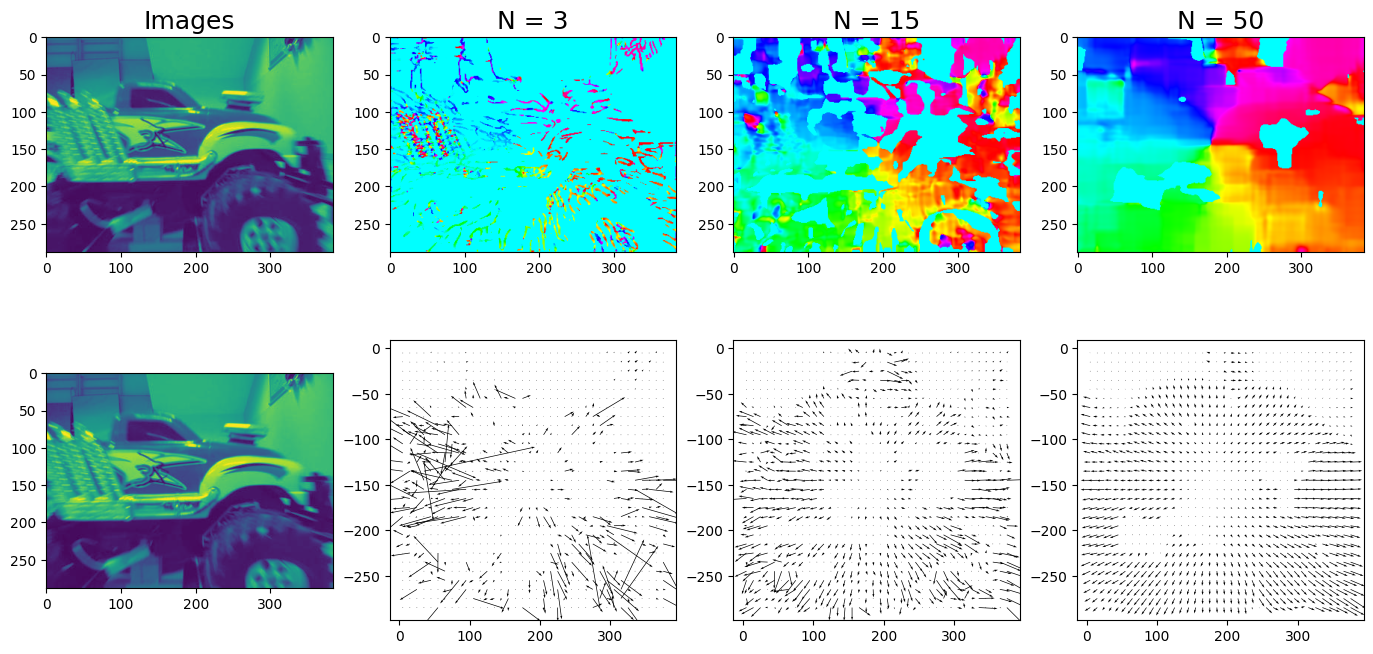

In [7]:
# Test different parameters
# im1 = cv2.imread("collision/00000001.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("collision/00000002.jpg", cv2.IMREAD_GRAYSCALE)/255.0

# for N in (3,9,15,35, 50, 100):
#     print(N, sigma)
#     subplot_field_lk(im1,im2, N=N, harris=True, sigma=sigma)


im1 = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0
sigma = int(im1.shape[1] /170.0)
# for N in (3,9,15,35, 50, 100):
#     print(N, sigma)
#     subplot_field_lk(im1,im2, N=N, harris=True, sigma=sigma)


# Subplot for report
fig,ax = plt.subplots(2,4, figsize=(17,8))
ax_11, ax_12, ax_13, ax_14 = ax[0]
ax_21, ax_22, ax_23, ax_24 = ax[1]

ax_11.set_title("Images", fontsize=18)
ax_12.set_title("N = 3", fontsize=18)
ax_13.set_title("N = 15", fontsize=18)
ax_14.set_title("N = 50", fontsize=18)

# Display images
ax_11.imshow(im1)
ax_21.imshow(im2)
# Get LK flow and display it
U,V = lucaskanade(im1,im2, 3, sigma, True)
show_flow(U, V, ax_12, type="angle")
show_flow(U,V, ax_22, type = "field")
# Get HS flow and display it 
U,V = lucaskanade(im1,im2, 15, sigma, True)
show_flow(U, V, ax_13, type="angle")
show_flow(U,V, ax_23, type = "field")
U,V = lucaskanade(im1,im2, 50, sigma, True)
show_flow(U, V, ax_14, type="angle")
show_flow(U,V, ax_24, type = "field")
    
fig.savefig("report/figures/LK_params.png")


999
999
999
999


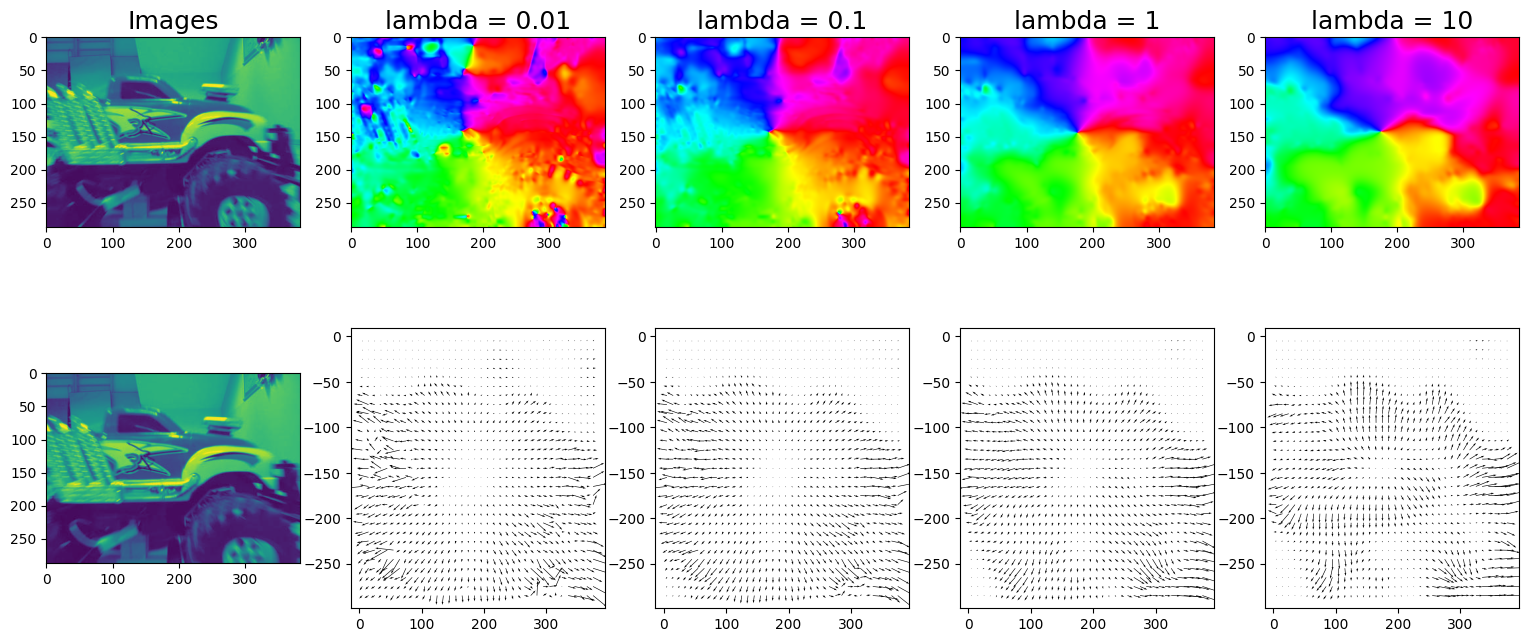

In [ ]:
# for horn-schnuck
sigma = int(im1.shape[1] /170.0)
# im1 = cv2.imread("collision/00000001.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("collision/00000002.jpg", cv2.IMREAD_GRAYSCALE)/255.0


# for lmbd in (0.001,0.01, 0.1, 1, 10,100,1000):
#     print(lmbd)
#     subplot_field_hc(im1,im2, n_iters = 1000, lmbd=lmbd, sigma=sigma, convergence_tresh=-1)


im1 = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0

# for lmbd in (0.001,0.01, 0.1, 1, 10,100,1000):
#     print(lmbd)
#     subplot_field_hc(im1,im2, n_iters = 1000, lmbd=lmbd, sigma=sigma, convergence_tresh=-1)

# Subplot for report
fig,ax = plt.subplots(2,5, figsize=(19,8))
ax_11, ax_12, ax_13, ax_14, ax_15 = ax[0]
ax_21, ax_22, ax_23, ax_24, ax_25 = ax[1]

ax_11.set_title("Images", fontsize=18)
ax_12.set_title("lambda = 0.01", fontsize=18)
ax_13.set_title("lambda = 0.1", fontsize=18)
ax_14.set_title("lambda = 1", fontsize=18)
ax_15.set_title("lambda = 10", fontsize=18)

# Display images
ax_11.imshow(im1)
ax_21.imshow(im2)
# Get LK flow and display it
U,V = hornschunck(im1,im2, n_iters = 1000, lmbd=0.01, sigma=sigma)
show_flow(U, V, ax_12, type="angle")
show_flow(U,V, ax_22, type = "field")
# Get HS flow and display it 
U,V = hornschunck(im1,im2, n_iters = 1000, lmbd=0.1, sigma=sigma)
show_flow(U, V, ax_13, type="angle")
show_flow(U,V, ax_23, type = "field")
U,V = hornschunck(im1,im2, n_iters = 1000, lmbd=1, sigma=sigma)
show_flow(U, V, ax_14, type="angle")
show_flow(U,V, ax_24, type = "field")
U,V = hornschunck(im1,im2, n_iters = 1000, lmbd=10, sigma=sigma)
show_flow(U, V, ax_15, type="angle")
show_flow(U,V, ax_25, type = "field")
    
fig.savefig("report/figures/HS_params.png")

## Time measurements

In [ ]:
#  Measuring the average times for LK and HS
sigma = im1.shape[1] /170.0
im1a = cv2.imread("lab2/007.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2a = cv2.imread("lab2/008.jpg",cv2.IMREAD_GRAYSCALE)/255.0

im1b = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2b = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0

im1c = cv2.imread("disparity/cporta_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2c = cv2.imread("disparity/cporta_right.png", cv2.IMREAD_GRAYSCALE)/255.0

# Lukas kanade time measurement, taking 2 images and repeating 10 times
N  = 3
time = []
for i in range(10):
    start_lk = timer()
    lucaskanade(im1a,im2a, N, sigma)
    lucaskanade(im1b,im2b, N, sigma)
    lucaskanade(im1c,im2c, N, sigma)
    stop_lk = timer()
    time.append((stop_lk -start_lk)/3)
print(f"Average time for the lukas kanade optical flow method: {np.mean(time)} +/- {np.std(time)/np.sqrt(10)} seconds")

# Horn-Schnuck
time = []
for i in range(10):
 
    lmbd = 0.5
    n_iters = 10000
    convergence = 1e-7
    start_hs = timer()
    hornschunck(im1a,im2a,n_iters, lmbd, sigma, convergence)
    hornschunck(im1b,im2b,n_iters, lmbd, sigma, convergence)
    hornschunck(im1c,im2c,n_iters, lmbd, sigma, convergence)
    stop_hs = timer()
    time.append((stop_hs - start_hs)/3)
print(f"Average time for the Horn-schnuck optical flow method:  {np.mean(time)} +/- {np.std(time)/np.sqrt(10)} seconds")


Average time for the lukas kanade optical flow method: 0.031017060000037115 +/- 0.00012144747796578679 seconds
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
1212
709
419
Average time for the Horn-schnuck optical flow method:  6.549123906666682 +/- 0.015201379971119094 seconds


### Using lukas kanade as input for Horn-Schnuck

419


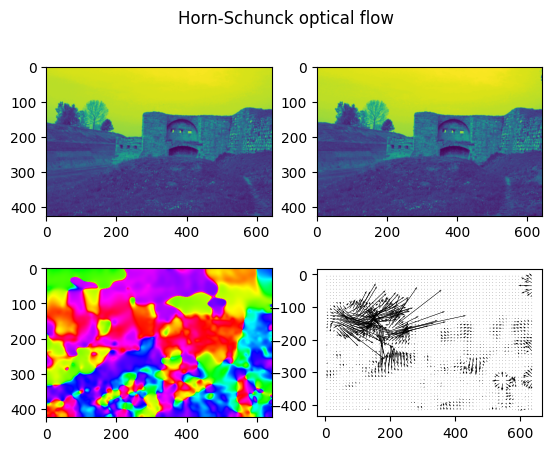

393


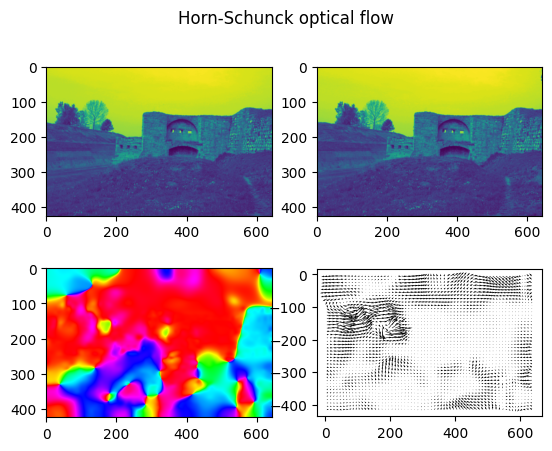

In [21]:
# Example
im1 = cv2.imread("disparity/cporta_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/cporta_right.png", cv2.IMREAD_GRAYSCALE)/255.0

N = 50 # Only works with a large neighbourhood
sigma = im1.shape[1] /170.0
lmbd = 0.5
convergence = 1e-7
#subplot_field_lk(im1,im2,N,sigma, True)
subplot_field_hc(im1,im2, 2000, lmbd, sigma,convergence, "Horn-Schunck optical flow")
u_lk, v_lk = lucaskanade(im1, im2, N, sigma, False)
subplot_field_hc(im1,im2, 2000, lmbd, sigma,convergence, "Horn-Schunck optical flow", u_start = u_lk, v_start=v_lk)

419


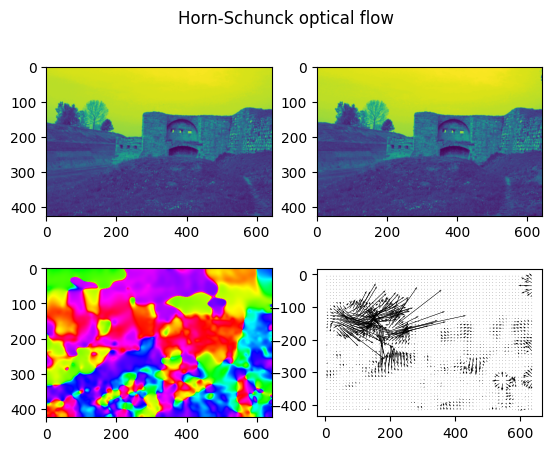

393


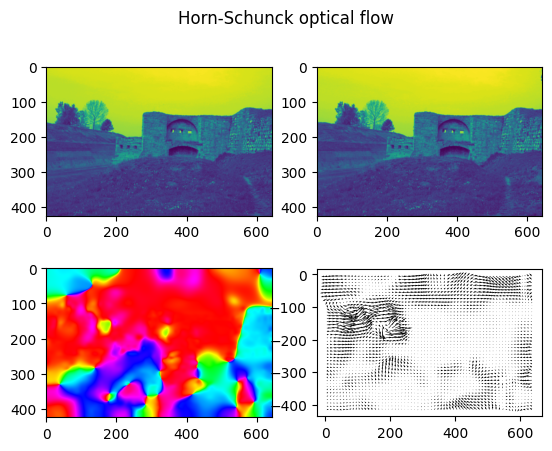

697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
697
200
393
Average time for the Horn-schnuck with LK input optical flow method:  4.267927410000085 +/- 0.007696945100291872 seconds


In [ ]:

# Time it
sigma = im1.shape[1] /170.0
im1a = cv2.imread("lab2/007.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2a = cv2.imread("lab2/008.jpg",cv2.IMREAD_GRAYSCALE)/255.0

im1b = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
im2b = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0

im1c = cv2.imread("disparity/cporta_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2c = cv2.imread("disparity/cporta_right.png", cv2.IMREAD_GRAYSCALE)/255.0

start = timer()
u_lk, v_lk = lucaskanade(im1a,im2a, N, sigma)
hornschunck(im1a,im2a,2000, lmbd, sigma,convergence, start_u = u_lk,start_v=v_lk)
u_lk, v_lk = lucaskanade(im1b,im2b, N, sigma)
hornschunck(im1b,im2b,2000, lmbd, sigma,convergence, start_u  = u_lk, start_v=v_lk)
u_lk, v_lk = lucaskanade(im1c,im2c, N, sigma)
hornschunck(im1c,im2c,2000, lmbd, sigma,convergence, start_u  = u_lk, start_v=v_lk)
stop = timer()
time = []
for i in range(10):
    # Horn-Schnuck 
    start = timer()
    u_lk, v_lk = lucaskanade(im1a,im2a, N, sigma)
    hornschunck(im1a,im2a,2000, lmbd, sigma,convergence, start_u = u_lk,start_v=v_lk)
    u_lk, v_lk = lucaskanade(im1b,im2b, N, sigma)
    hornschunck(im1b,im2b,2000, lmbd, sigma,convergence, start_u  = u_lk, start_v=v_lk)
    u_lk, v_lk = lucaskanade(im1c,im2c, N, sigma)
    hornschunck(im1c,im2c,2000, lmbd, sigma,convergence, start_u  = u_lk, start_v=v_lk)
    stop = timer()
    time.append((stop - start)/3)
    
print(f"Average time for the Horn-schnuck with LK input optical flow method:  {np.mean(time)} +/- {np.std(time)/np.sqrt(10)} seconds")


## Implementing the pyramidial structure

In [65]:
def warp_with_flow_field(image, u, v):
    """Function for inverse warping images with the given flow u, v"""
    # Get coordinate matrices
    h, w = image.shape

    x,y = np.meshgrid(np.arange(w), np.arange(h))

    # Add the flow field to the coordinate matrices, to tell cv2 where to map the pixels
    map_x = (x - u).astype(np.float32)
    map_y = (y - v).astype(np.float32)
    warped = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)

    return warped




def pyramidial_lucaskanade (im1, im2, N,sigma=1, repeat = 1):
    """Function for calculating the optical flow using the Lucas-Kanade method"""
    # Get the pyramids
    image_list1 = []
    image_list2 = []
    # While we are in the range where some movement can still exist
    while min(im1.shape) > N*4:
        image_list2.append(im2)
        image_list1.append(im1)

        sigma =im1.shape[1] /170.0
        im1 = gausssmooth(im1, sigma)
        im2 = gausssmooth(im2, sigma)
    
        new_shape = (int(im1.shape[1]/2), int(im1.shape[0]/2))
        im1 = cv2.resize(im1, new_shape)
        im2 = cv2.resize(im2, new_shape)
        

    sigma = im1.shape[1] /170.0
    # Compute the flow for the smallest images
    u_prev,v_prev = lucaskanade(im1,im2, N, sigma, True)


    for image1, image2 in zip(image_list1[::-1], image_list2[::-1]):
        # Repeat multiple times on the same scale
        for k in range(repeat):
            # Update the sigma according to the size of the image
            sigma = im1.shape[1] /170.0
            # upsample the flow to be able to warp the next image, double it since distances have to be doubled

            u_prev = 2*cv2.resize(u_prev, image1.T.shape)
            v_prev= 2*cv2.resize(v_prev,image1.T.shape)
            # Warp the image with the previously calculated flow
            warped_im2 = warp_with_flow_field(image2, u_prev,v_prev)

            u_res,v_res = lucaskanade(image1,warped_im2,N, sigma, True)
            u_prev += u_res
            v_prev += v_res

    return u_prev, v_prev


In [90]:
def subplot_field_lk_pyramid(im1, im2, N, sigma, title=""):
    """Function for subploting pyrmidial implementation of lukas-kanade for testing"""
    fig1, ax = plt.subplots(2, 2)

    ax1_11, ax1_12 = ax[0]
    ax1_21, ax1_22 = ax[1]

    ax1_11.imshow(im1)
    ax1_12.imshow(im2)

    U, V = pyramidial_lucaskanade(im1,im2, N, sigma)
    show_flow(U, V, ax1_21, type="angle")
    show_flow(U, V, ax1_22, type="field", set_aspect=True)

    fig1.suptitle(title)
    
    plt.show()

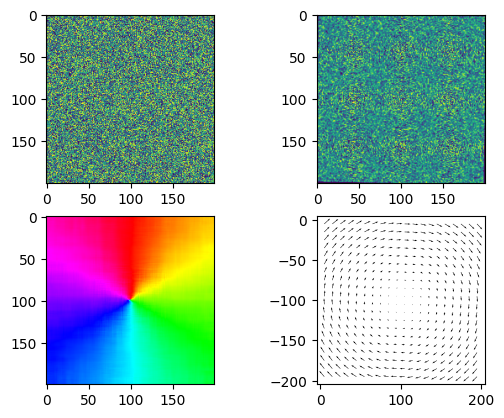

In [91]:
# For starters test on noise
np.random.seed(42)
im1 = np.random.rand(200,200).astype(np.float32)
im2 = im1.copy()
im2 = rotate_image(im2,-1)

sigma = im1.shape[1] /170.0
N = 15 #for LK
subplot_field_lk_pyramid(im1,im2,N, sigma)

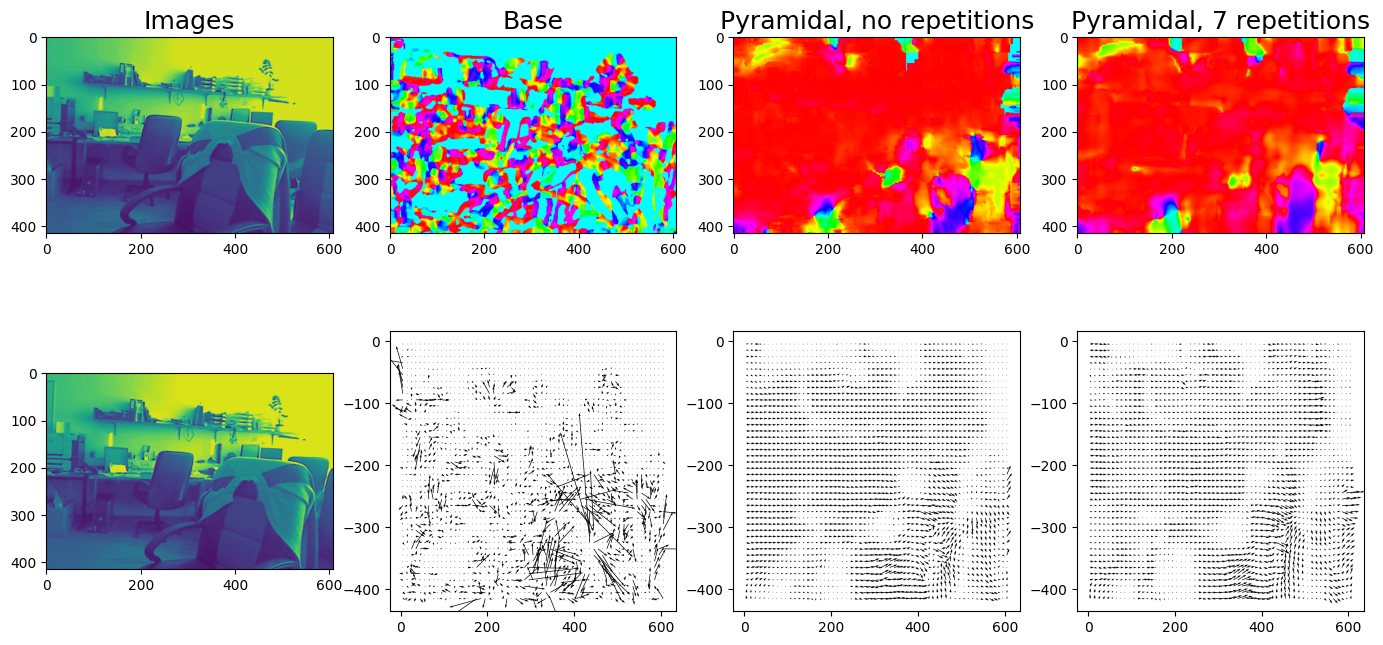

In [ ]:
# Test on real-world video
im1 = cv2.imread("disparity/office_left.png", cv2.IMREAD_GRAYSCALE)/255.0
im2 = cv2.imread("disparity/office_right.png",cv2.IMREAD_GRAYSCALE)/255.0
# im1 = cv2.imread("lab2/001.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("lab2/002.jpg",cv2.IMREAD_GRAYSCALE)/255.0
# im1 = cv2.imread("collision/00000181.jpg", cv2.IMREAD_GRAYSCALE)/255.0
# im2 = cv2.imread("collision/00000182.jpg", cv2.IMREAD_GRAYSCALE)/255.0
N = 15 #for LK  
sigma = im1.shape[1] /170.0
# subplot_field_lk(im1,im2,N, sigma, True)
# subplot_field_lk_pyramid(im1,im2,N, sigma) 

# Report 
N = 15
# Subplot for report
fig,ax = plt.subplots(2,4, figsize=(17,8))
ax_11, ax_12, ax_13, ax_14 = ax[0]
ax_21, ax_22, ax_23, ax_24 = ax[1]

ax_11.set_title("Images", fontsize=18)
ax_12.set_title("Base", fontsize=18)
ax_13.set_title("Pyramidal, no repetitions", fontsize=18)
ax_14.set_title("Pyramidal, 7 repetitions", fontsize=18)

# Display images
ax_11.imshow(im1)
ax_21.imshow(im2)

U,V = lucaskanade(im1,im2, N, sigma, True)
show_flow(U, V, ax_12, type="angle")
show_flow(U,V, ax_22, type = "field")

U,V = pyramidial_lucaskanade(im1,im2, N, sigma, 1)
show_flow(U, V, ax_13, type="angle")
show_flow(U,V, ax_23, type = "field")

U,V = pyramidial_lucaskanade(im1,im2, N, sigma, 7)
show_flow(U, V, ax_14, type="angle")
show_flow(U,V, ax_24, type = "field")

fig.savefig("report/figures/pyramidal.png")